In [1]:
import sbi
from sbi.inference import SNLE
import torch

data_store = []



import jax
import jax.numpy as jnp
import numpy as np


from markovsbi.tasks import get_task
from markovsbi.bm.api_utils import get_window_torch

sbi.__version__

'0.23.1'

In [240]:

dim = 10
key_number = 4



key = jax.random.PRNGKey(key_number)

task = get_task("simple{}dnonstationary".format(dim))
prior = task.get_prior()
simulator = task.get_simulator()


data = task.get_data(key, 10_000, 2 , max_T = 1000)

In [241]:
from numpy import indices

d = task.input_shape[0]
print('d:', d)
prior_torch = torch.distributions.Independent(torch.distributions.Normal(torch.zeros(d), torch.ones(d)),1)
inf = SNLE(prior_torch, density_estimator = 'maf')


thetas = data["thetas"]
xs = data["xs"]
ts = data["ts"]

thetas = torch.tensor(np.array(thetas), dtype=torch.float32)
xs = torch.tensor(np.array(xs), dtype=torch.float32)
xs = xs.reshape(xs.shape[0], -1)
ts = torch.tensor(np.array(ts), dtype=torch.float32)

xs = torch.concatenate([xs, ts], dim=1)
T = int(xs.shape[1])





inf.append_simulations(thetas, xs)



density_estimator = inf.train(training_batch_size = 1000, learning_rate=1e-3, validation_fraction=0.1, stop_after_epochs=20, max_num_epochs=2147483647, clip_max_norm=5.0)
posterior = inf.build_posterior(sample_with = "mcmc", mcmc_method = "slice_np_vectorized", mcmc_parameters = {'num_chains': 100})


d: 10
 Neural network successfully converged after 232 epochs.

/opt/anaconda3/lib/python3.11/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


In [252]:
xs.shape, thetas.shape

theta_o = prior.sample(key)
num_obs = 2


x_o = torch.tensor(np.array(simulator(key, theta_o, num_obs)))
t_o = torch.tensor(np.arange(num_obs , dtype=jnp.float32)).reshape(-1, 1)


x_o_window = get_window_torch(x_o, 2)
t_o_window = get_window_torch(t_o, 2)



x_o_window  = torch.concatenate([x_o_window, t_o_window], dim=1)
print(x_o_window.shape)


torch.Size([1, 22])


In [253]:
print('window:', x_o_window.shape)

n_samples = 1000
x_o = torch.tensor(np.array(x_o))
posterior._x_shape = (1, x_o.shape[0], x_o.shape[1])
samples = posterior.sample((n_samples,), x=x_o_window, show_progress_bars=False)


window: torch.Size([1, 22])
input_x_shape: torch.Size([1, 22])
x_event_shape: None
input_x_shape: torch.Size([1, 22])
x_event_shape: None


In [254]:


true_posterior = task.get_true_posterior(jnp.array(np.array(x_o)))
true_samples = true_posterior.sample(key, (1000,))
true_samples = torch.tensor(np.array(true_samples))



from sbi.utils.metrics import c2st

distance = c2st(torch.tensor(np.array(samples))[:1000], true_samples[:1000])

10
(1, 10)
(1, 10)


/var/folders/wt/2fn1yjbn3rd4mbn_1xf9746w0000gn/T/ipykernel_95697/2717239092.py:5: UserWarning: offdiag is deprecated, use upper or lower instead.
  pairplot([np.array(samples), true_samples], points = np.array(theta_o), limits = [(-5,5)]*10, offdiag="scatter")


(<Figure size 1000x1000 with 100 Axes>,
 array([[<Axes: xlabel='dim 1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: xlabel='dim 2'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: xlabel='dim 3'>, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: xlabel='dim 4'>, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: xlabel='dim 5'>,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: xlabel='dim 6'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: xlabel='dim 7'>, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, 

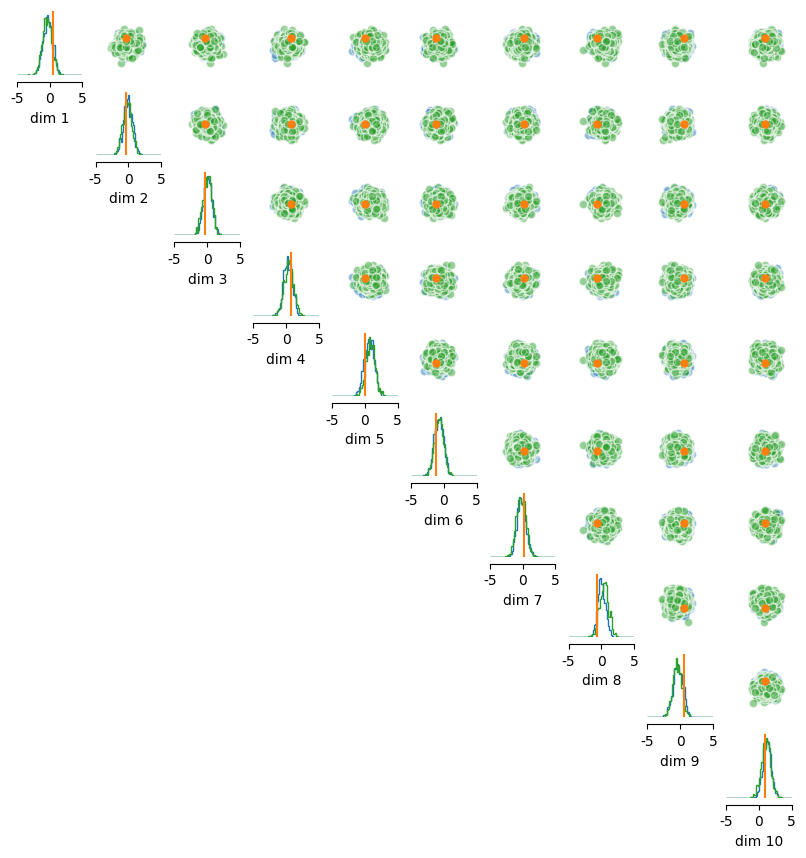

In [255]:
from sbi.analysis import pairplot
import numpy as np


pairplot([np.array(samples), true_samples], points = np.array(theta_o), limits = [(-5,5)]*10, offdiag="scatter")

In [256]:
data_store_local = []


data_store_local.append(dim)
data_store_local.append(key_number)
data_store_local.append(num_obs)
data_store_local.append(distance)

data_store.append(np.array(data_store_local))
#print(data_store_local)

#print(data_store)



import pandas as pd

sample = pd.DataFrame(data_store, columns=['dim', 'key_number', 'obs_length','C2ST'])
print(sample)
sample.to_csv('Nonstationary_{}_10k.csv'.format("NLE"))

     dim  key_number  obs_length    C2ST
0    1.0         0.0       101.0  0.5730
1    1.0         0.0        11.0  0.7435
2    1.0         0.0         2.0  0.5375
3    1.0         1.0       101.0  0.9825
4    1.0         1.0        11.0  0.8100
5    1.0         1.0         2.0  0.5265
6    1.0         2.0       101.0  0.6710
7    1.0         2.0        11.0  0.5985
8    1.0         2.0         2.0  0.5005
9    1.0         3.0       101.0  0.9920
10   1.0         3.0        11.0  0.9595
11   1.0         3.0         2.0  0.5465
12   1.0         4.0       101.0  0.4945
13   1.0         4.0        11.0  0.6920
14   1.0         4.0         2.0  0.4885
15   2.0         0.0       101.0  0.5805
16   2.0         0.0        11.0  0.7285
17   2.0         0.0         2.0  0.4970
18   2.0         1.0       101.0  1.0000
19   2.0         1.0        11.0  0.9805
20   2.0         1.0         2.0  0.5400
21   2.0         2.0       101.0  0.9895
22   2.0         2.0        11.0  0.9440
23   2.0        